# Intellijoint Advanced Researcher - Technical Assessment
## Authored by: Samuel Newhook

### Requirements
Jupyter Notebook is required to run this file. Installation guide [here](https://jupyter.org/install).
All packages required will need to be installed if not already. One debugging note is that if the package stl is already installed there may be some issues with from stl import mesh. If this happens, uninstall stl and numpy-stl and then reinstall numpy-stl as recommended [here](https://stackoverflow.com/questions/29661823/importing-of-3d-stl-image-in-python-importerror-no-module-named-ascii).

### Introduction
This project is a naive x-ray simulation. It is based on the idea that a simplified x-ray emitter can be modelled as a point source and a detector. By projecting rays along lines that run from the emitter to evenly sampled points on the detector, we can detect any objects in the path of the rays by attenuating the signal when the ray and the object intersect. To do this, we sample along each line for a certain number of time steps. At each test point at each time step we simply calculate whether or not the test point is located inside one of the stl meshes that we have loaded.

### External Libraries
External Libraries include some standard python libraries such as numpy, os and matplotlib. The library numpy-stl is used for dealing with stl files. A link to documentation can be found [here](https://pypi.org/project/numpy-stl/). A link to the winding algorithm for determining points in a polygon can be found [here](http://geomalgorithms.com/a03-_inclusion.html).

In [10]:
import numpy
from numpy import linalg as LA
import os
import nipype.interfaces.meshfix as mf
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
from numba import cuda
%matplotlib notebook

In [12]:
class Plane:
    ''' Plane of form ax + by + cz = d
        Load any three points as pts [p0; p1; p2] where pn is [x, y, z]
    '''
    def __init__(self, pts):
        self._a, self._b, self._c, self._d = self._plane_from_points(pts)
        abs_abc = numpy.absolute([self._a, self._b, self._c])
        self._max_ind_norm = numpy.where(abs_abc == numpy.max(abs_abc))[0]
        
    def _plane_from_points(self, pts:numpy.array):
        v1 = pts[2, :] - pts[0, :]
        v2 = pts[1, :] - pts[0, :]
        cp = numpy.cross(v1, v2)
        a, b, c = cp
        d = numpy.dot(cp, pts[2, :])
        return a, b, c, d
    
    def intersection_pt(self, line):
        plane_abc = numpy.array([self._a, self._b, self._c])
        denom = numpy.dot(plane_abc, line.slope)
        if denom == 0:
            return numpy.array([numpy.nan, numpy.nan, numpy.nan]), numpy.nan
        s = (self._d - numpy.dot(plane_abc, line.initial_pt)) / denom
        return line.get_point_on_line(s), s
    
    def get_y_given_xz(self, x, z):
        y = (self._d - self._a * x - self._c * z) / self._b
        return y
    
    @property
    def largest_index_in_norm(self):
        return self._max_ind_norm
        
    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b
    
    @property
    def c(self):
        return self._c
    
    @property
    def d(self):
        return self._d
    
    @property
    def is_vertical(self):
        return self._b == 0
    
class LineSegment:
    ''' Generates a line segment object given two points
        Load any two points as pts [p0; p1] where pn is [x, y, z]
        The line segment spans p0 --> p1
    '''
    def __init__(self, pts):
        self._slope, self._initial_pt, self._final_pt = self._line_from_pts(pts)
        self._segment_length = LA.norm(self._final_pt - self._initial_pt)
        
    def _line_from_pts(self, pts):
        xs = pts[1, 0] - pts[0, 0]
        ys = pts[1, 1] - pts[0, 1]
        zs = pts[1, 2] - pts[0, 2]
        slope = numpy.array([xs, ys, zs])
        norm_slope = slope / LA.norm(slope)
        xi = pts[0, 0]
        yi = pts[0, 1]
        zi = pts[0, 2]
        return norm_slope, numpy.array([xi, yi, zi]), numpy.array([pts[1, 0], pts[1, 1], pts[1, 2]])
    
    def get_point_on_line(self, s):
        return self._slope * s + self._initial_pt
    
    def vec_along_slope(self, s):
        return self._slope * s
    
    @property
    def slope(self):
        return self._slope
    
    @property
    def initial_pt(self):
        return self._initial_pt
    
    @property
    def final_pt(self):
        return self._final_pt
    
    @property
    def segment_length(self):
        return self._segment_length

#The following three functions are used to determine if a point is inside a polygon
def is_left(p0, p1, p2):
    # tests if a point is Left|On|Right of an infinite line.
    # Input:  three points P0, P1, and P2
    # Return: >0 for P2 left of the line through P0 and P1
    # =0 for P2  on the line
    # <0 for P2  right of the line
    return ((p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1]))

def proj_2d(p_gon, pt):
    # Make 2d simply by discarding an axis
    plane = Plane(p_gon)
    discard_ind = plane.largest_index_in_norm[0]
    return numpy.delete(p_gon, discard_ind, 1), numpy.delete(pt, discard_ind)

def is_point_in_polygon(p_gon, test_point) -> bool:
    p_gon_2d, pt_2d = proj_2d(p_gon, test_point)
    wn = 0
    for edge_ind in range(0, p_gon_2d.shape[0]):
        vertex_i = p_gon_2d[edge_ind]
        vertex_i_plus_1 = p_gon_2d[edge_ind + 1] if edge_ind + 1 != p_gon_2d.shape[0] else p_gon_2d[0]
        if vertex_i[1] <= pt_2d[1]:
            if vertex_i_plus_1[1] > pt_2d[1]:
                if is_left(vertex_i, vertex_i_plus_1, pt_2d) > 0:
                    wn += 1
        else:
            if vertex_i_plus_1[1] <= pt_2d[1]:
                if is_left(vertex_i, vertex_i_plus_1, pt_2d) < 0:
                    wn -= 1
    return wn != 0

class X_Ray_Simulator:
    ''' Class for performing x_ray_simulations
        Currently immutable.
        Create a simulator with x_ray_sim = X_Ray_Simulator(filename)
        Get the pixels with pixels = x_ray_sim.simulate()
        Automatically attempts to place the emitter and detector screen at appropriate locations
    '''
    def __init__(self, stl_filename, num_pixels_w=5, num_pixels_l=5, num_slices=10, scaling_factor=3):
        sample_mesh = mesh.Mesh.from_file(stl_filename)
        self._num_pixels_w = num_pixels_w
        self._num_pixels_l = num_pixels_l
        self._num_slices = num_slices
        volume, cog, inertia = sample_mesh.get_mass_properties()
        t_form = numpy.eye(4)
        t_form[:, 3] = numpy.array(numpy.concatenate((-cog, numpy.ones(1)))).T
        sample_mesh.transform(t_form)
        self._mesh = sample_mesh
        scale = numpy.max(numpy.abs(sample_mesh.points.flatten(order='C')))
        screen_offset = scale * scaling_factor
        screen_size = scale * 2 * scaling_factor
        center_pos = 0
        pt_offset = -screen_offset
        self._emitter_pt = numpy.array([center_pos, pt_offset, center_pos])
        self._screen = numpy.array([[-screen_size, screen_offset, -screen_size],
                                    [screen_size, screen_offset, -screen_size], 
                                    [screen_size, screen_offset, screen_size], 
                                    [-screen_size, screen_offset, screen_size]])
        self._pixels = numpy.zeros((self._num_pixels_w, self._num_pixels_l))
        
    def simulate(self):
        self._pixels = numpy.zeros((self._num_pixels_w, self._num_pixels_l))
        
        all_lines = self._get_lines_to_screen()
        
        max_seg_length = numpy.max(numpy.array([loi.segment_length for loi in all_lines.reshape(all_lines.size)]))

        s_at_verts = numpy.linspace(0, max_seg_length, self._num_slices)
        
        self._simulate_detector(all_lines, s_at_verts)
        
        return self._pixels

        
    
    def _get_lines_to_screen(self):
        limits_of_integration = [LineSegment(numpy.array([self._emitter_pt, scr_pt])) for scr_pt in self._screen]

        line_segment_of_integration = [LineSegment(
            numpy.vstack((limits_of_integration[0].final_pt, limits_of_integration[1].final_pt))),
                                      LineSegment(
            numpy.vstack((limits_of_integration[0].final_pt, limits_of_integration[3].final_pt)))]

        linspace_s_0 = numpy.linspace(0, line_segment_of_integration[0].segment_length, self._num_pixels_w)
        linspace_s_1 = numpy.linspace(0, line_segment_of_integration[1].segment_length, self._num_pixels_l)

        return numpy.array([[LineSegment(numpy.vstack((self._emitter_pt, limits_of_integration[0].get_point_on_line(limits_of_integration[0].segment_length) + line_segment_of_integration[0].vec_along_slope(s_0) + line_segment_of_integration[1].vec_along_slope(s_1)))) for s_0 in linspace_s_0] for s_1 in linspace_s_1])
    
    def _simulate_detector(self, all_lines, s_at_verts):
        for line_idx, segment_s in enumerate(s_at_verts):
            for x_idx, test_line_row in enumerate(all_lines):
                for z_idx, test_line in enumerate(test_line_row):
                    s_list = []
                    face_intersect_count = 0
                    test_pt = test_line.get_point_on_line(segment_s)
                    axes.scatter(test_pt[0], test_pt[1], test_pt[2])
                    test_pt_vert = test_pt + numpy.array([0, 1, 0])
                    for vec in self._mesh.vectors:
                        plane = Plane(vec)
                        test_line = LineSegment(numpy.array([test_pt, test_pt_vert]))
                        intersect, s = plane.intersection_pt(test_line)
                        is_in_pgon = is_point_in_polygon(vec, intersect) if not numpy.isnan(s) else False
                        if is_in_pgon and not s in s_list and s >= 0:
                            face_intersect_count += 1
                            s_list.append(s)
                    attenuate = face_intersect_count % 2 != 0
                    if attenuate:
                        self._pixels[x_idx, z_idx] += 1
    @property
    def emitter_pt(self):
        return self._emitter_pt
    
    @property
    def screen(self):
        return self._screen
    
    @property
    def mesh(self):
        return self._mesh

<IPython.core.display.Javascript object>


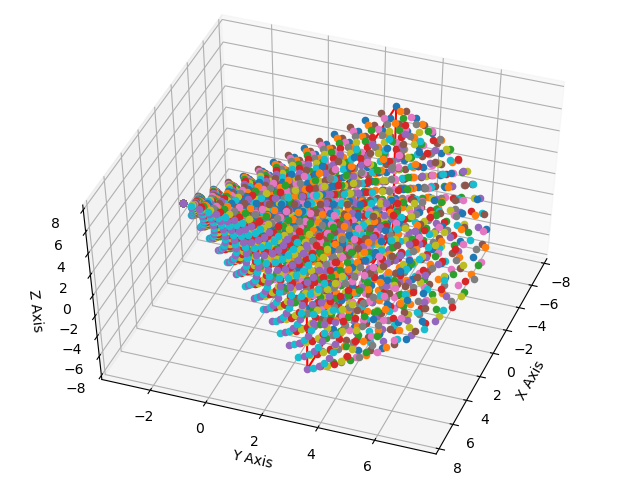

<IPython.core.display.Javascript object>


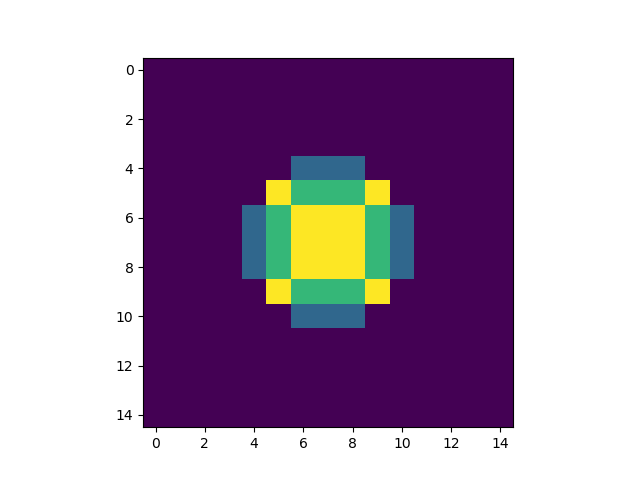

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 2. 2. 2. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 3. 3. 3. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 3. 3. 3. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 3. 3. 3. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 2. 2. 2. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
x_ray_sim = X_Ray_Simulator('cube.stl', num_pixels_w = 15, num_pixels_l = 15, num_slices = 15)

figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(x_ray_sim.mesh.vectors))

emitter_pt = x_ray_sim.emitter_pt
axes.scatter(emitter_pt[0], emitter_pt[1], emitter_pt[2], color='green')

screen = x_ray_sim.screen

plt_screen = numpy.vstack((screen, screen[0])).T

axes.plot(plt_screen[0], 
          plt_screen[1], 
          plt_screen[2], 
          color='red')

axes.set_xlabel('X Axis')
axes.set_ylabel('Y Axis')
axes.set_zlabel('Z Axis')

pixels = x_ray_sim.simulate()
pyplot.savefig('test_points_.png')
pyplot.figure()
pyplot.imshow(pixels)
print(pixels)
pyplot.savefig('scan.png')
pyplot.show()